### 1: IMPORT LIBRARIES DAN SETUP 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### 2: LOAD DATA DAN PREPROCESSING

In [3]:
# Load dataset ratings dan metadata game
ratings_df = pd.read_csv('../data/game_ratings.csv')
games_df = pd.read_csv('../data/games_metadata_5k.csv')

print(f"Dataset: {ratings_df.shape[0]} ratings, {ratings_df['user_id'].nunique()} users, {ratings_df['game_id'].nunique()} games")

Dataset: 273669 ratings, 10000 users, 5000 games


In [4]:
# Filter data sparse - hanya ambil user dan game dengan minimal 5 rating
MIN_RATINGS = 5
user_counts = ratings_df.groupby('user_id').size()
game_counts = ratings_df.groupby('game_id').size()

filtered_ratings = ratings_df[
    (ratings_df['user_id'].isin(user_counts[user_counts >= MIN_RATINGS].index)) &
    (ratings_df['game_id'].isin(game_counts[game_counts >= MIN_RATINGS].index))
]

In [5]:
n_users, n_games = filtered_ratings['user_id'].nunique(), filtered_ratings['game_id'].nunique()
sparsity = 1 - (len(filtered_ratings) / (n_users * n_games))
print(f"Setelah filtering: {len(filtered_ratings)} ratings, {n_users} users, {n_games} games")
print(f"Matrix sparsity: {sparsity:.2%}")

Setelah filtering: 273669 ratings, 10000 users, 5000 games
Matrix sparsity: 99.45%


### 3: VISUALISASI DISTRIBUSI DATA

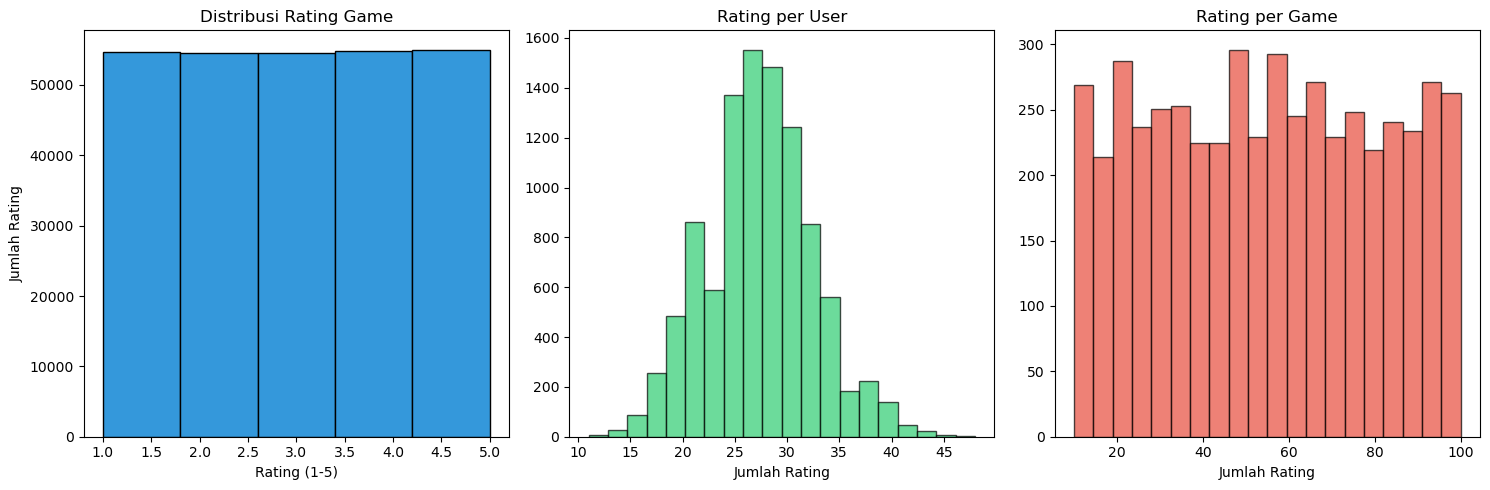

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Distribusi nilai rating (1-5)
axes[0].hist(filtered_ratings['rating'], bins=5, color='#3498db', edgecolor='black')
axes[0].set_title('Distribusi Rating Game')
axes[0].set_xlabel('Rating (1-5)')
axes[0].set_ylabel('Jumlah Rating')

# Distribusi rating per user
user_rating_counts = filtered_ratings.groupby('user_id').size()
axes[1].hist(user_rating_counts, bins=20, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1].set_title('Rating per User')
axes[1].set_xlabel('Jumlah Rating')

# Distribusi rating per game
game_rating_counts = filtered_ratings.groupby('game_id').size()
axes[2].hist(game_rating_counts, bins=20, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[2].set_title('Rating per Game')
axes[2].set_xlabel('Jumlah Rating')

plt.tight_layout()
plt.show()

### 4: SPLIT DATA DAN BUAT USER-ITEM MATRIX

In [9]:
# Split data 80:20 untuk training dan testing
test_indices = np.random.choice(filtered_ratings.index, size=int(len(filtered_ratings) * 0.2), replace=False)
test_set = filtered_ratings.loc[test_indices]
train_set = filtered_ratings.drop(test_indices)

print(f"Training: {len(train_set)} ratings | Testing: {len(test_set)} ratings")

Training: 218936 ratings | Testing: 54733 ratings


In [10]:
# Buat user-item matrix dari training data
user_item_matrix = pd.pivot_table(train_set, values='rating', index='user_id', columns='game_id', fill_value=0)

# Hitung rata-rata rating per game untuk mean-centering
game_means = train_set.groupby('game_id')['rating'].mean()


### 5: HITUNG ITEM SIMILARITY MATRIX

In [12]:
# Mean-centering: kurangi rating dengan rata-rata game untuk menghilangkan bias
centered_ratings = train_set.copy()
centered_ratings['rating_centered'] = centered_ratings.apply(lambda row: row['rating'] - game_means[row['game_id']], axis=1)

# Buat item-user matrix yang sudah di-center
item_user_centered = pd.pivot_table(centered_ratings, values='rating_centered', index='game_id', columns='user_id', fill_value=0)

In [13]:
# Hitung cosine similarity antar game
item_similarity = cosine_similarity(item_user_centered)
similarity_df = pd.DataFrame(item_similarity, index=item_user_centered.index, columns=item_user_centered.index)
np.fill_diagonal(similarity_df.values, 0)  # Hapus self-similarity

print(f"Item Similarity Matrix: {similarity_df.shape}")
print(f"Rata-rata similarity: {similarity_df.values[similarity_df.values != 0].mean():.4f}")

Item Similarity Matrix: (5000, 5000)
Rata-rata similarity: -0.0000


### 6: VISUALISASI SIMILARITY MATRIX

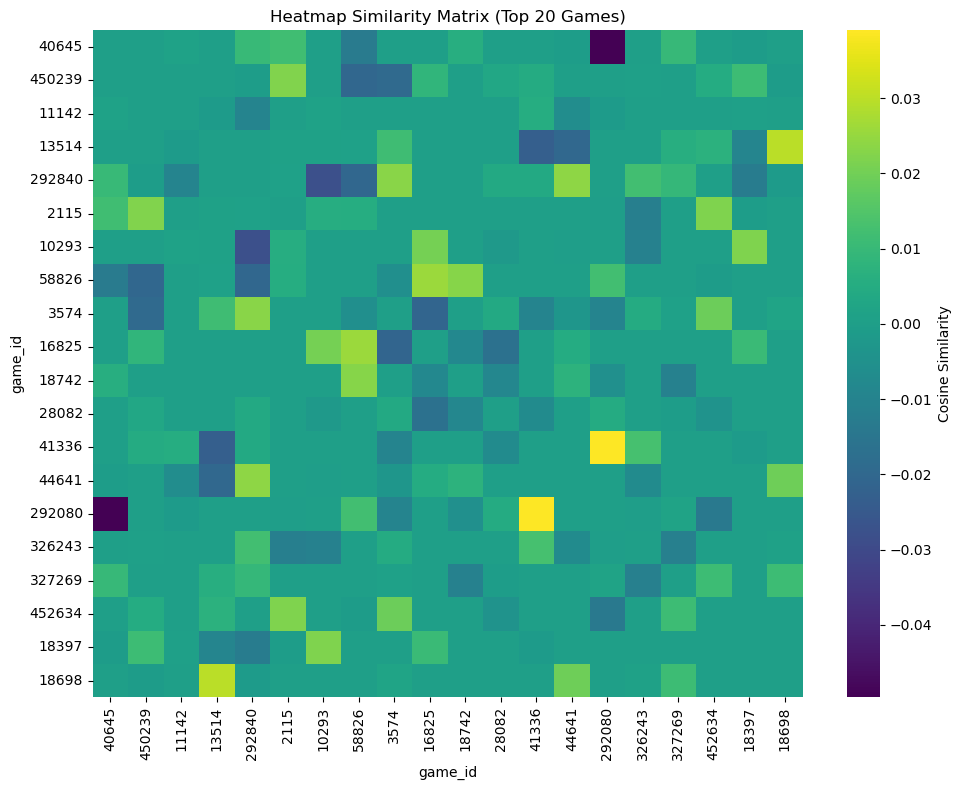

In [14]:
# Heatmap similarity untuk 20 game paling populer
top_games = train_set.groupby('game_id').size().nlargest(20).index
similarity_subset = similarity_df.loc[top_games, top_games]

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_subset, cmap='viridis', cbar_kws={'label': 'Cosine Similarity'})
plt.title('Heatmap Similarity Matrix (Top 20 Games)')
plt.tight_layout()
plt.show()

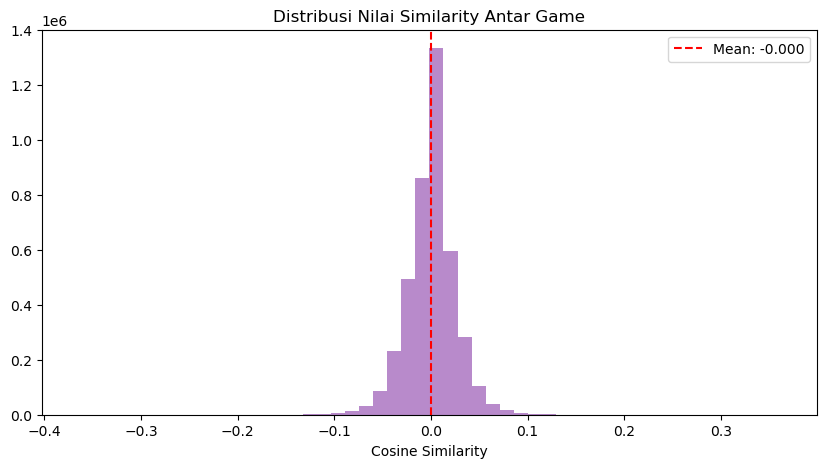

In [15]:
# Distribusi nilai similarity
similarity_values = similarity_df.values[similarity_df.values != 0]
plt.figure(figsize=(10, 5))
plt.hist(similarity_values, bins=50, color='#9b59b6', alpha=0.7)
plt.axvline(similarity_values.mean(), color='red', linestyle='--', label=f'Mean: {similarity_values.mean():.3f}')
plt.title('Distribusi Nilai Similarity Antar Game')
plt.xlabel('Cosine Similarity')
plt.legend()
plt.show()

### 7: FUNGSI PREDIKSI RATING

In [17]:
def predict_rating(user_id, game_id, k=20):
    """Prediksi rating menggunakan Item-Based Collaborative Filtering"""
    # Jika user/game tidak ada, return rata-rata game
    if user_id not in user_item_matrix.index or game_id not in similarity_df.index:
        return game_means.get(game_id, 3.0)
    
    # Ambil game yang sudah dirating user
    user_ratings = user_item_matrix.loc[user_id]
    rated_games = user_ratings[user_ratings > 0]
    
    if len(rated_games) == 0:
        return game_means.get(game_id, 3.0)
    
    # Ambil k tetangga terdekat berdasarkan similarity
    similarities = similarity_df.loc[game_id, rated_games.index].nlargest(k)
    
    if len(similarities) == 0 or similarities.sum() == 0:
        return game_means.get(game_id, 3.0)
    
    # Hitung weighted average: rata-rata game + weighted sum of deviations
    base_rating = game_means.get(game_id, 3.0)
    weighted_sum = sum(sim * (rating - game_means.get(gid, 3.0)) 
                      for sim, (gid, rating) in zip(similarities, rated_games[similarities.index].items()))
    
    prediction = base_rating + weighted_sum / similarities.abs().sum()
    return max(1.0, min(5.0, prediction))  # Batasi rating 1-5


### 8: EVALUASI MODEL DENGAN BERBAGAI NILAI K

In [18]:
k_values = [5, 10, 15, 20, 25, 30, 40, 50]
results = []

# Sample 1000 data test untuk evaluasi cepat
test_sample = test_set.sample(n=min(1000, len(test_set)), random_state=42)

In [19]:
print("Evaluating different K values...")
for k in k_values:
    predictions = [predict_rating(row['user_id'], row['game_id'], k) for _, row in test_sample.iterrows()]
    actuals = test_sample['rating'].tolist()
    
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    results.append({'k': k, 'rmse': rmse, 'mae': mae})

results_df = pd.DataFrame(results)

Evaluating different K values...


### 9: VISUALISASI HASIL EVALUASI

In [21]:
optimal_k = results_df.loc[results_df['rmse'].idxmin(), 'k']
best_rmse = results_df['rmse'].min()
best_mae = results_df['mae'].min()

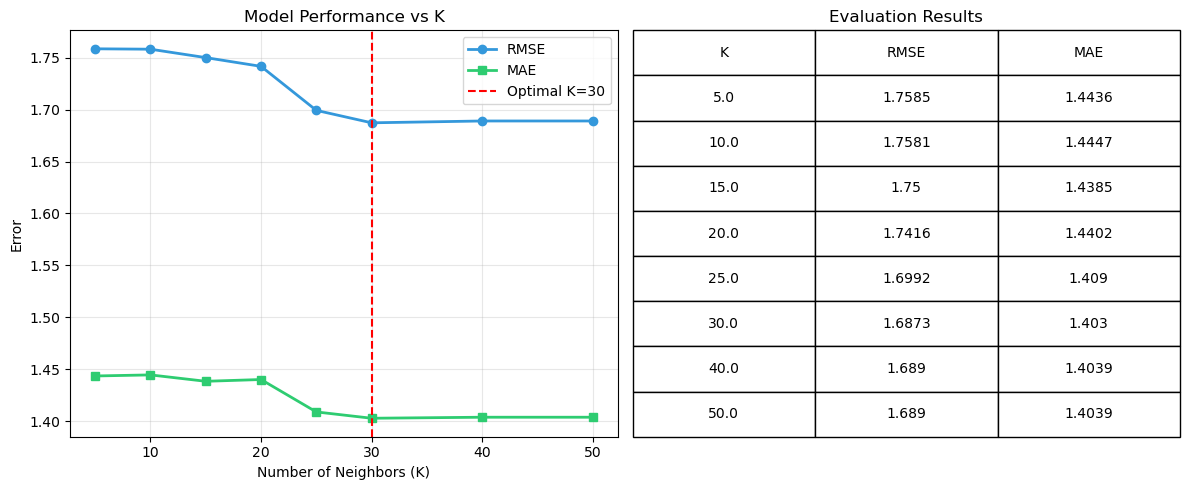

Optimal K: 30 | Best RMSE: 1.6873 | Best MAE: 1.4030


In [22]:
plt.figure(figsize=(12, 5))

# Plot RMSE dan MAE
plt.subplot(1, 2, 1)
plt.plot(results_df['k'], results_df['rmse'], 'o-', color='#3498db', linewidth=2, label='RMSE')
plt.plot(results_df['k'], results_df['mae'], 's-', color='#2ecc71', linewidth=2, label='MAE')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
plt.title('Model Performance vs K')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error')
plt.legend()
plt.grid(alpha=0.3)

# Tabel hasil evaluasi
plt.subplot(1, 2, 2)
plt.axis('off')
table_data = results_df.round(4).values
plt.table(cellText=table_data, colLabels=['K', 'RMSE', 'MAE'], 
          cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
plt.title('Evaluation Results')

plt.tight_layout()
plt.show()

print(f"Optimal K: {optimal_k} | Best RMSE: {best_rmse:.4f} | Best MAE: {best_mae:.4f}")

### 10: GENERATE REKOMENDASI

In [24]:
def get_recommendations(user_id, n_recommendations=5):
    """Generate top-N rekomendasi game untuk user"""
    if user_id not in user_item_matrix.index:
        return []
    
    # Ambil game yang belum dirating
    user_ratings = user_item_matrix.loc[user_id]
    unrated_games = user_ratings[user_ratings == 0].index
    
    # Prediksi rating untuk semua game yang belum dirating
    predictions = []
    for game_id in unrated_games:
        pred_rating = predict_rating(user_id, game_id, k=optimal_k)
        game_name = games_df[games_df['game_id'] == game_id]['name'].iloc[0] if not games_df[games_df['game_id'] == game_id].empty else f"Game {game_id}"
        predictions.append({'game_id': game_id, 'name': game_name, 'predicted_rating': pred_rating})
    
    # Urutkan berdasarkan predicted rating tertinggi
    recommendations = sorted(predictions, key=lambda x: x['predicted_rating'], reverse=True)
    return recommendations[:n_recommendations]

In [25]:
# Contoh rekomendasi untuk 3 sample users
sample_users = np.random.choice(user_item_matrix.index, 3, replace=False)

for user_id in sample_users:
    print(f"\n=== REKOMENDASI UNTUK USER {user_id} ===")
    
    # Tampilkan 3 game yang sudah dirating tertinggi
    user_rated = user_item_matrix.loc[user_id]
    top_rated = user_rated[user_rated > 0].nlargest(3)
    
    print("Game yang disukai (Top 3):")
    for game_id, rating in top_rated.items():
        game_name = games_df[games_df['game_id'] == game_id]['name'].iloc[0] if not games_df[games_df['game_id'] == game_id].empty else f"Game {game_id}"
        print(f"  - {game_name}: {rating}")
    
    # Generate dan tampilkan rekomendasi
    recommendations = get_recommendations(user_id)
    print(f"\nRekomendasi Game (K={optimal_k}):")
    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec['name']} (Rating: {rec['predicted_rating']:.2f})")



=== REKOMENDASI UNTUK USER user_5080 ===
Game yang disukai (Top 3):
  - Pinball FX2: 5.0
  - The First Tree: 5.0
  - Call of Duty: Advanced Warfare - Gold Edition: 5.0

Rekomendasi Game (K=30):
  1. Prey (Rating: 5.00)
  2. Oxenfree (Rating: 5.00)
  3. Deus Ex: The Fall (Rating: 5.00)
  4. Warhammer 40,000: Space Wolf (Rating: 5.00)
  5. Neverwinter (Rating: 5.00)

=== REKOMENDASI UNTUK USER user_3659 ===
Game yang disukai (Top 3):
  - ARCADE GAME SERIES: DIG DUG: 5.0
  - LittleBigPlanet: 5.0
  - Western Press: 5.0

Rekomendasi Game (K=30):
  1. Destiny 2 (Rating: 5.00)
  2. Kingdom: New Lands (Rating: 5.00)
  3. Oxenfree (Rating: 5.00)
  4. Resident Evil 7: Biohazard (Rating: 5.00)
  5. Motorsport Manager (Rating: 5.00)

=== REKOMENDASI UNTUK USER user_7354 ===
Game yang disukai (Top 3):
  - Borderlands 2: 5.0
  - Company of Heroes 2: 5.0
  - Dungeon of Zolthan: 5.0

Rekomendasi Game (K=30):
  1. This is the Police (Rating: 5.00)
  2. Sniper Elite 4 (Rating: 5.00)
  3. How to Survive

### 11: RINGKASAN HASIL

In [26]:
print("\n" + "="*60)
print("RINGKASAN SISTEM REKOMENDASI GAME")
print("="*60)
print(f"Dataset: {len(filtered_ratings)} ratings dari {n_users} users untuk {n_games} games")
print(f"Matrix Sparsity: {sparsity:.2%}")
print(f"Algoritma: Item-Based Collaborative Filtering")
print(f"Similarity Measure: Cosine Similarity (Mean-Centered)")
print(f"Optimal K: {optimal_k} neighbors")
print(f"Performance - RMSE: {best_rmse:.4f} | MAE: {best_mae:.4f}")
print("="*60)


RINGKASAN SISTEM REKOMENDASI GAME
Dataset: 273669 ratings dari 10000 users untuk 5000 games
Matrix Sparsity: 99.45%
Algoritma: Item-Based Collaborative Filtering
Similarity Measure: Cosine Similarity (Mean-Centered)
Optimal K: 30 neighbors
Performance - RMSE: 1.6873 | MAE: 1.4030
